In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

# KBMOD Coadd Stamps

## README

The following data was generated for use as part of the [KBMOD](https://github.com/dirac-institute/kbmod) project, for the purpose of creating a machine learning model to filter out false positve results from the KBMOD search. The data set is divided into two sets of data, the true positive and false positive, with each set also divided into the training, validation, and test sets for ML purposes.

### True Positive

This dataset was generated based on the synthetic objects inserted into the DEEP data by Pedro Bernardinelli, and then cutout from the survey dataset by Steven Stetzler. The original stamp cutouts are available on hyak at `/gscratch/dirac/DEEP/collab/fakes_cutouts/data/*/npy` (the `*` being the id of the fake object in DEEP).

### False Positive

This dataset was generated by running KBMOD on the DEEP data, but setting the set of serach angles to be roughly perpendicular to the ecliptic. This allows us to semi-safely assume that any search results are not real or inserted objects (i.e., while some real or synthetic objects may have been included in this set, the ratio to bad results is small enough to not be of concern for machine learning purposes).

### Data Transformation

Each source observation in the above set was ran through a series of random transformations, to enlarge the dataset and to capture all possible features of both sets. Those transformations were:
- select a random subset of the total set to coadd, with a minimum number of observations set to 25
    - so if the N number of observations is > 25 then the set of stamps used in coadding is of length [25,N]
- potentially offset the center pixel of each stamp by one in either direction, for both the X and Y in pixel space
    - so the set x_offset = [-1, 0, 1] and y_offset = [-1, 0, 1], creating nine potential offset states around the "actual" center of the object/results.
- potentially mirror around both the x and y axis
- potentially rotate 90 degrees around the center N times, where N is [0-3]

### Data Format

The data arrays are stored as numpy `.npy` files, and can be loaded with `x = np.load(PATH)`.

The shape of the data is `(N, 3, 21, 21)`, where N is the number of individual stamps in each set. The second dimmension corresponds to the type of coadd performed.
- index 0 = median coadd stamp
- index 1 = mean coadd stamp
- index 2 = sum coadd stamp.
Side note: the true positive stamp files also have an index 3, which corresponds to the recently added variance weighted coadd stamps. However, we found some discrepancies in those stamps and decided not to generate them for the false positive stamp. You can filter out this fourth column from the true positive set by slicing the array like [:,:3,:,:].

Each coadd stamp has the shape (21,21).

## Data

Here are the preloaded data sets. If you want to generate your own train, test, and validation sets, you can load in the `true_positive_stamps_full.npy` and `false_positive_stamps_full.npy` files.

In [2]:
# As i am using Colab:
from google.colab import drive
import pandas as pd

# Monta Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = "/content/drive/MyDrive/Astroinformatica/kbmod_ml_stamps/"

# TRUE POSITVE PATHS
true_pos_full = os.path.join(data_dir, "true_positive_stamps_full.npy")
true_pos_train = os.path.join(data_dir, "true_train_stamps.npy")
true_pos_valid = os.path.join(data_dir, "true_valid_stamps.npy")
true_pos_test = os.path.join(data_dir, "true_test_stamps.npy")

# FALSE POSITVE PATHS
false_pos_full = os.path.join(data_dir, "false_positive_stamps_full.npy")
false_pos_train = os.path.join(data_dir, "false_train_stamps.npy")
false_pos_valid = os.path.join(data_dir, "false_valid_stamps.npy")
false_pos_test = os.path.join(data_dir, "false_test_stamps.npy")

In [4]:
true_train = np.load(true_pos_train)[:,:3,:,:] # this indexing isn't strictly needed if you're just grabbing one of the other coadd type columns, see below cell.
true_test = np.load(true_pos_test)[:,:3,:,:]

false_train = np.load(false_pos_train)

true_train.shape, false_train.shape

((129010, 3, 21, 21), (110530, 3, 21, 21))

In [5]:
true_train_median = true_train[:,0,:,:]
false_train_median = false_train[:,0,:,:]

true_train_median.shape, false_train_median.shape

((129010, 21, 21), (110530, 21, 21))

In [6]:
true_valid  = np.load(true_pos_valid)[:,:3,:,:]
false_valid = np.load(false_pos_valid)[:,:3,:,:]
true_valid.shape, false_valid.shape

((36860, 3, 21, 21), (31580, 3, 21, 21))

In [7]:
true_test  = np.load(true_pos_test)[:,:3,:,:]
false_test = np.load(false_pos_test)[:,:3,:,:]
true_test.shape, false_test.shape

((18430, 3, 21, 21), (15790, 3, 21, 21))

## Visualization

If you want to visualize what certain stamps look like, you can use `plt.imshow` and pass in the desired row.

Side note on visualizing the true positive stamps: we specifically weakened the signal on some of the observations to simulate a wider range of data. Visualizing some of the stamps might seem like mostly random noise, but I do promise there is signal there. Some of the time the PSF isn't visible in the median stamp but is seen in the mean or sum, or vice versa. I'm still messing around with the dataset so if we're running into too much low-SNR contimination in this set, we can raise the minimum observations in the selection algorithm and rerun everything, it only takes about 20 minutes to do :)

In [44]:
def plot_true_false(true, false):
    '''Plot a random set of true and false images'''
    fig_0,ax_0 = plt.subplots(nrows=2,ncols=5,figsize=[8,4])
    fig_1,ax_1 = plt.subplots(nrows=2,ncols=5,figsize=[8,4])
    ax_0 = ax_0.reshape(-1)
    ax_1 = ax_1.reshape(-1)
    true_int_list = np.random.choice(len(true),10,replace=False)
    false_int_list = np.random.choice(len(false),10,replace=False)
    for i, ax in enumerate(ax_0):
        ax.imshow(true[true_int_list[i]])
    for i, ax in enumerate(ax_1):
        ax.imshow(false[false_int_list[i]])
    fig_0.suptitle('True',fontsize=16)
    fig_1.suptitle('False',fontsize=16)
    fig_0.tight_layout()
    fig_1.tight_layout()

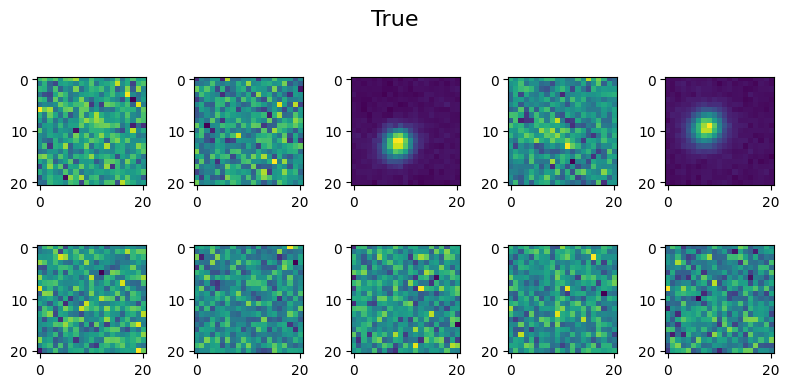

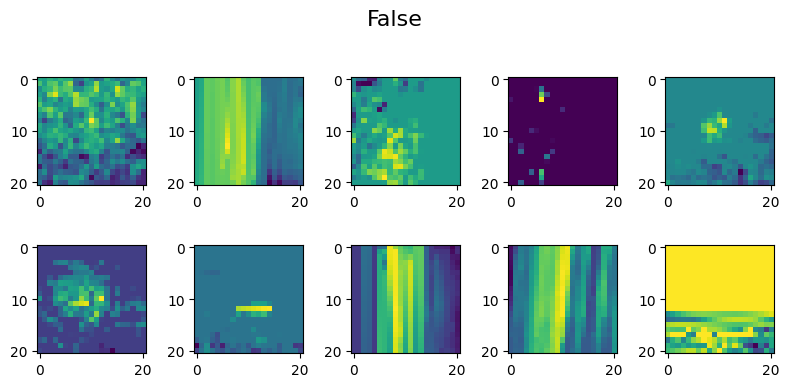

In [ ]:
plot_true_false(true_train[:,0,:,:], false_train[:,0,:,:])

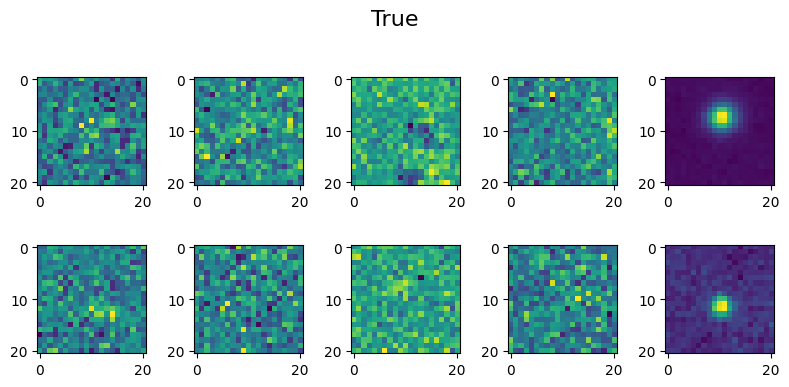

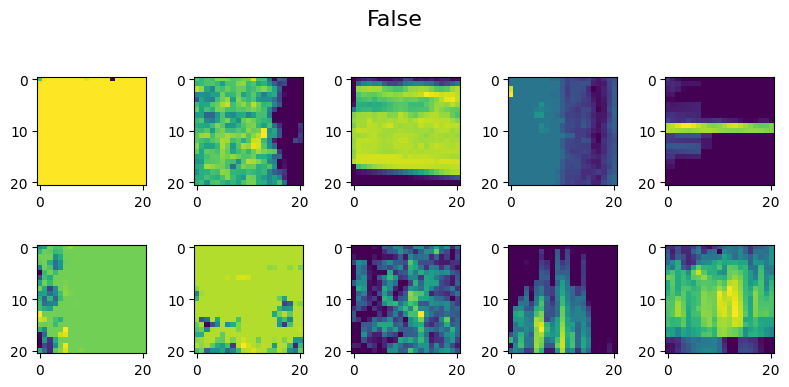

In [45]:
plot_true_false(true_test[:,0,:,:], false_test[:,0,:,:])

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K

In [9]:
def normalization(array, new_max: float = 1, new_min:float = 0):
    new_array = (array - array.min()) * (new_max - new_min) / (array.max() - array.min()) + new_min
    return new_array

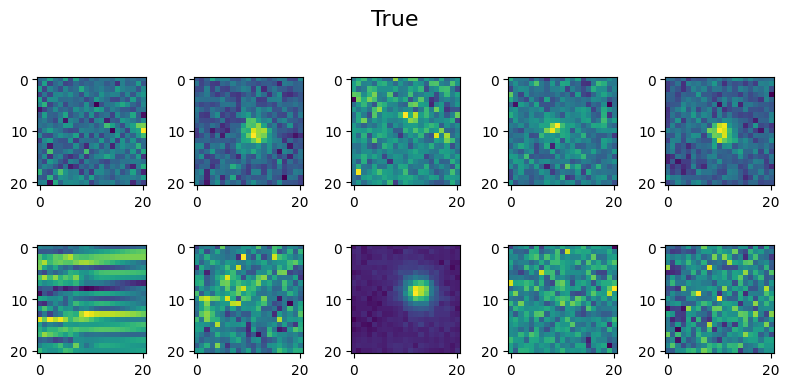

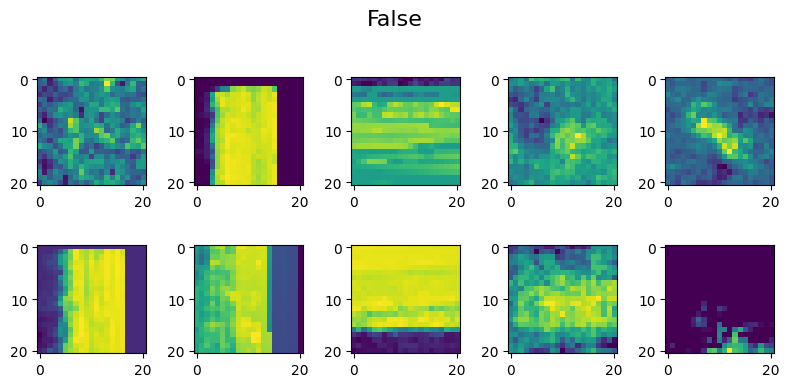

In [ ]:
plot_true_false(true_train_median, false_train_median)

In [10]:
false_train_median, true_train_median = normalization(false_train_median), normalization(true_train_median)
#plot_true_false(true_train_median, false_train_median)

In [11]:
# combine data
def stack_data(f, t):
    input_stamps = np.vstack([f, t])
    stamp_class = np.zeros(len(f) + len(t))
    stamp_class[len(f):] = 1

    rand_state = np.random.RandomState(32)
    idx = rand_state.permutation(len(input_stamps))
    input_stamps = input_stamps[idx]
    stamp_class = stamp_class[idx]
    stamp_class = to_categorical(stamp_class)
    return input_stamps, stamp_class

In [12]:
# false_pos_valid = os.path.join(data_dir, "false_valid_stamps.npy")
# _a = np.load(false_pos_valid)

In [50]:
true_valid_median  = normalization(np.load(true_pos_valid)[:,0,:,:])
false_valid_median = normalization(np.load(false_pos_valid)[:,0,:,:])

true_test_median  = normalization(np.load(true_pos_test)[:,0,:,:])
false_test_median = normalization(np.load(false_pos_test)[:,0,:,:])

train_data, train_class = stack_data(false_train_median, true_train_median)
val_data, val_class     = stack_data(false_valid_median, true_valid_median)
test_data, test_class   = stack_data(false_test_median, true_test_median)

# Reshape [Channel, Heigh, Width]
train_data = train_data.reshape(-1,21,21,1)
val_data = val_data.reshape(-1,21,21,1)
test_data  = test_data.reshape(-1,21,21,1)

In [ ]:
# true_valid_median = np.load(true_pos_valid)[:,0,:,:]
# false_valid_median = np.load(false_pos_valid)[:,0,:,:]

# train_data, train_class = stack_data(false_train_median, true_train_median)
# val_data, val_class = stack_data(false_valid_median, true_valid_median)

# train_data = train_data.reshape(-1,21,21,1)
# val_data = val_data.reshape(-1,21,21,1)

## Training

I've included a simple model here as jumping off point. Go wild!

In [14]:
train_class.shape, train_data.shape, val_class.shape, val_data.shape

((239540, 2), (239540, 21, 21, 1), (68440, 2), (68440, 21, 21, 1))

In [ ]:
def simple_model(input_shape=(21,21,1), n_classes: int = 2):
    model = tf.keras.models.Sequential(name='simple')
    model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn1'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu', name='fc_1'))
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))
    return(model)

In [ ]:
simple_cnn = simple_model(input_shape=(21,21,1))
sgd = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.05, nesterov=True)
simple_cnn.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
n_epochs = 20
simple_model_history = simple_cnn.fit(train_data, train_class, epochs=n_epochs, batch_size=512, verbose=1, validation_data=(val_data, val_class), shuffle=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7476 - loss: 0.5402 - val_accuracy: 0.6701 - val_loss: 0.6515
Epoch 2/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9012 - loss: 0.3394 - val_accuracy: 0.8468 - val_loss: 0.6450
Epoch 3/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9032 - loss: 0.2824 - val_accuracy: 0.6834 - val_loss: 0.5957
Epoch 4/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9189 - loss: 0.2412 - val_accuracy: 0.6548 - val_loss: 0.6188
Epoch 5/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9221 - loss: 0.2217 - val_accuracy: 0.6280 - val_loss: 0.6283
Epoch 6/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9309 - loss: 0.2061 - val_accuracy: 0.6640 - val_loss: 0.6092
Epoch 7/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9231 - loss: 0.2050 - val_accuracy: 0.6708 - val_loss: 0.6073
Epoch 8/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9225 - loss: 0.2091 - val_accuracy: 

In [ ]:
simple_cnn.summary()

Model: "simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 19, 19, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1 (BatchNormalization)             │ (None, 19, 19, 8)           │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 9, 9, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 9, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 648)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 64)                  │          41,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_out (Dense)                       │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,542 (326.34 KB)

 Trainable params: 41,762 (163.13 KB)

 Non-trainable params: 16 (64.00 B)

 Optimizer params: 41,764 (163.14 KB)

Text(0, 0.5, 'Accuracy')

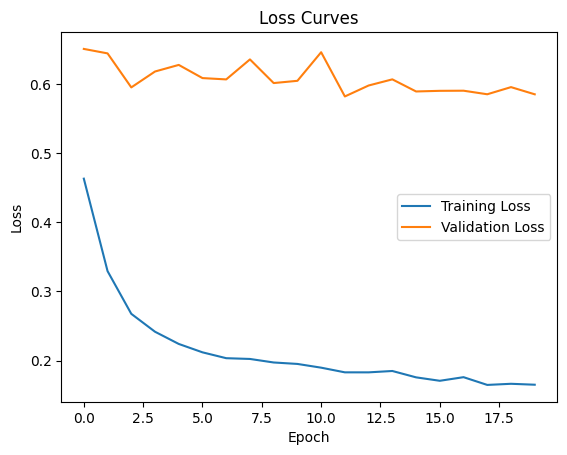

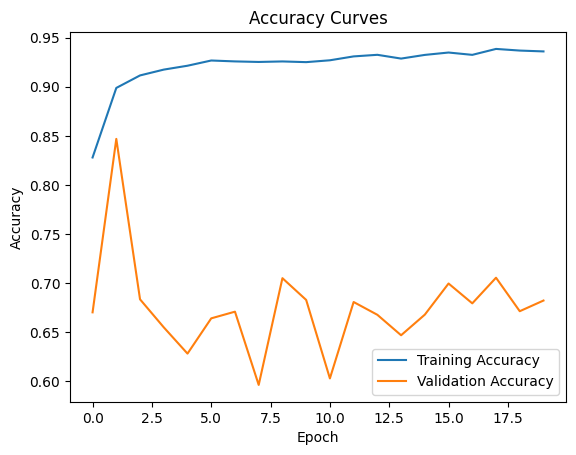

In [ ]:
model_history = simple_model_history
import matplotlib.pyplot as plt
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.figure()
plt.plot(np.arange(n_epochs), loss, label='Training Loss')
plt.plot(np.arange(n_epochs), val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig('Keras_Loss.png')
plt.figure()
plt.plot(np.arange(n_epochs), acc, label='Training Accuracy')
plt.plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.savefig('figures/ResNet50_LC.png')

576/576 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


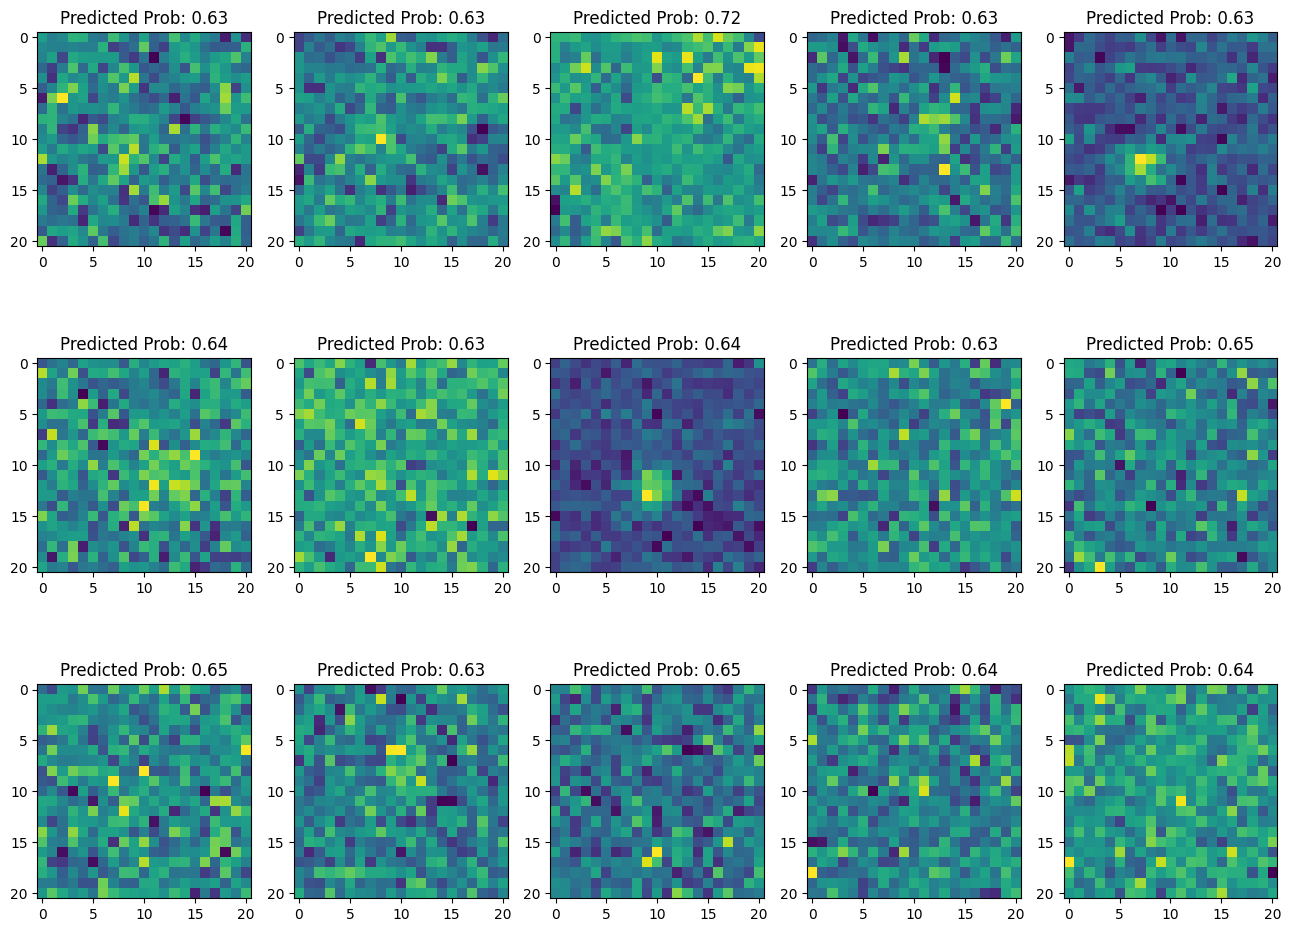

In [ ]:
real_positives = true_test[:,0,:,:]
real_data_probs = simple_cnn.predict(real_positives)
fig, ax = plt.subplots(nrows=3,ncols=5,figsize=[16,12])
ax = ax.reshape(-1)
[tmp_ax.set_axis_off() for tmp_ax in ax]
# Limit the loop to the number of subplots
for i,coadd in enumerate(real_positives[:len(ax)]):
    ax[i].set_axis_on()
    ax[i].imshow(coadd.reshape(21,21))
    ax[i].set_title('Predicted Prob: {:.2f}'.format(real_data_probs[i,1]))

In [ ]:
model_history?

## Pytorch

Problemos los resultados usando un modelo un poco mas complejo, e implementado en pytorch

In [ ]:
pip install torch pytorch-lightning

In [ ]:
pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics.classification import Accuracy

class ComplexModel(pl.LightningModule):
    def __init__(self, input_shape=(1, 21, 21), n_classes=2):
        super(ComplexModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(64 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, n_classes)

        self.activation = nn.Sigmoid() if n_classes == 1 else nn.Softmax(dim=1)

        # Métricas
        self.train_accuracy = Accuracy(task="binary" if n_classes == 1 else "multiclass", num_classes=n_classes)
        self.val_accuracy = Accuracy(task="binary" if n_classes == 1 else "multiclass", num_classes=n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = torch.flatten(x, 1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return self.activation(x)


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        # Calcula y registra la precisión
        self.train_accuracy(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_accuracy', self.train_accuracy, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        # Calcula y registra la precisión
        self.val_accuracy(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', self.val_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
from torchinfo import summary

# Define el tamaño de entrada (debe coincidir con el tamaño real de entrada)
summary(ComplexModel(input_shape=(1, 21, 21)), input_size=(1, 1, 21, 21))

Layer (type:depth-idx)                   Output Shape              Param #
ComplexModel                             [1, 2]                    --
├─Conv2d: 1-1                            [1, 16, 21, 21]           160
├─BatchNorm2d: 1-2                       [1, 16, 21, 21]           32
├─MaxPool2d: 1-3                         [1, 16, 10, 10]           --
├─Conv2d: 1-4                            [1, 32, 10, 10]           4,640
├─BatchNorm2d: 1-5                       [1, 32, 10, 10]           64
├─MaxPool2d: 1-6                         [1, 32, 5, 5]             --
├─Conv2d: 1-7                            [1, 64, 5, 5]             18,496
├─BatchNorm2d: 1-8                       [1, 64, 5, 5]             128
├─MaxPool2d: 1-9                         [1, 64, 2, 2]             --
├─Linear: 1-10                           [1, 128]                  32,896
├─Dropout: 1-11                          [1, 128]                  --
├─Linear: 1-12                           [1, 2]                    258
├

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name           | Type               | Params | Mode 
---------------------------------------------------------------
0  | conv1          | Conv2d             | 160    | train
1  | bn1            | BatchNorm2d        | 32     | train
2  | conv2          | Conv2d             | 4.6 K  | train
3  | bn2            | BatchNorm2d        | 64     | train
4  | conv3          | Conv2d             | 18.5 K | train
5  | bn3            | BatchNorm2d        | 128    | train
6  | pool           | MaxPool2d          | 0      | train
7  | dropout        | Dropout            | 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


<Figure size 1200x500 with 0 Axes>

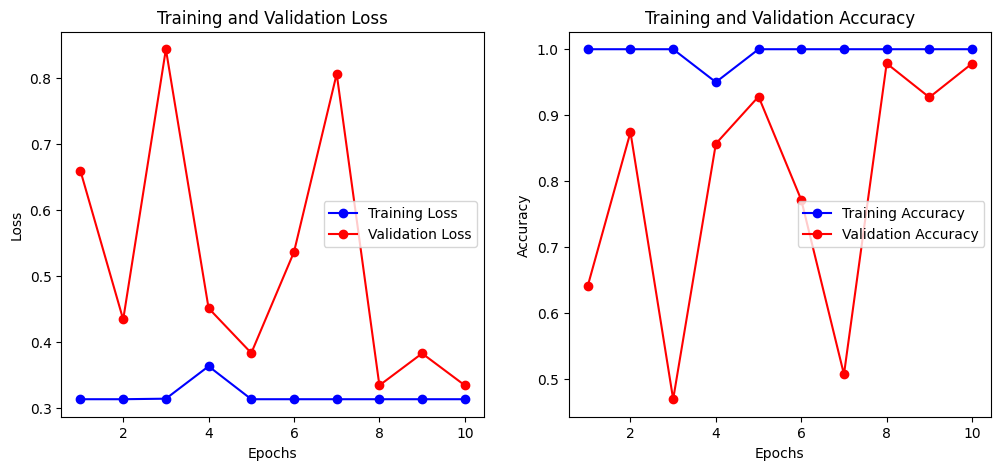

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Clase MetricsCallback para almacenar las metricas
class MetricsCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.metrics = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": []}

    def on_train_epoch_end(self, trainer, pl_module):
        # Metricas de entrenamiento
        self.metrics["train_loss"].append(trainer.callback_metrics["train_loss"].item())
        self.metrics["train_accuracy"].append(trainer.callback_metrics["train_accuracy"].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        # Métricas de validación
        self.metrics["val_loss"].append(trainer.callback_metrics["val_loss"].item())
        self.metrics["val_accuracy"].append(trainer.callback_metrics["val_accuracy"].item())


# Instancia del Callback
metrics_callback = MetricsCallback()

# Configuración opcional para reproducibilidad
pl.seed_everything(42)

# Convertir datos y etiquetas a tensores
train_data_tensor = torch.tensor(train_data, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, 1, 21, 21)
train_class_tensor = torch.tensor(train_class.argmax(axis=1), dtype=torch.long)  # Convertir etiquetas categóricas a formato de clase

val_data_tensor = torch.tensor(val_data, dtype=torch.float32).permute(0, 3, 1, 2)
val_class_tensor = torch.tensor(val_class.argmax(axis=1), dtype=torch.long)

# Crear conjuntos de datos y DataLoaders
train_dataset = TensorDataset(train_data_tensor, train_class_tensor)
val_dataset = TensorDataset(val_data_tensor, val_class_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


# Inicializa el modelo
model = ComplexModel(input_shape=(1, 21, 21), n_classes=2)


# Configuración del entrenador con el callback
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[metrics_callback]
)

# Entrena el modelo
trainer.fit(model, train_loader, val_loader)

# Extrae los valores de las métricas después del entrenamiento
train_loss = metrics_callback.metrics["train_loss"]
train_accuracy = metrics_callback.metrics["train_accuracy"]
val_loss = metrics_callback.metrics["val_loss"]
val_accuracy = metrics_callback.metrics["val_accuracy"]

# Graficar las curvas de pérdida y precisión
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Encuentra la longitud mínima entre todas las listas
min_len = min(len(epochs), len(train_loss), len(val_loss), len(train_accuracy), len(val_accuracy))

# Ajusta todas las listas para que tengan la misma longitud
epochs = epochs[:min_len]
train_loss = train_loss[:min_len]
val_loss = val_loss[:min_len]
train_accuracy = train_accuracy[:min_len]
val_accuracy = val_accuracy[:min_len]

# Graficar las curvas de pérdida de entrenamiento y validación
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Graficar las curvas de precisión de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

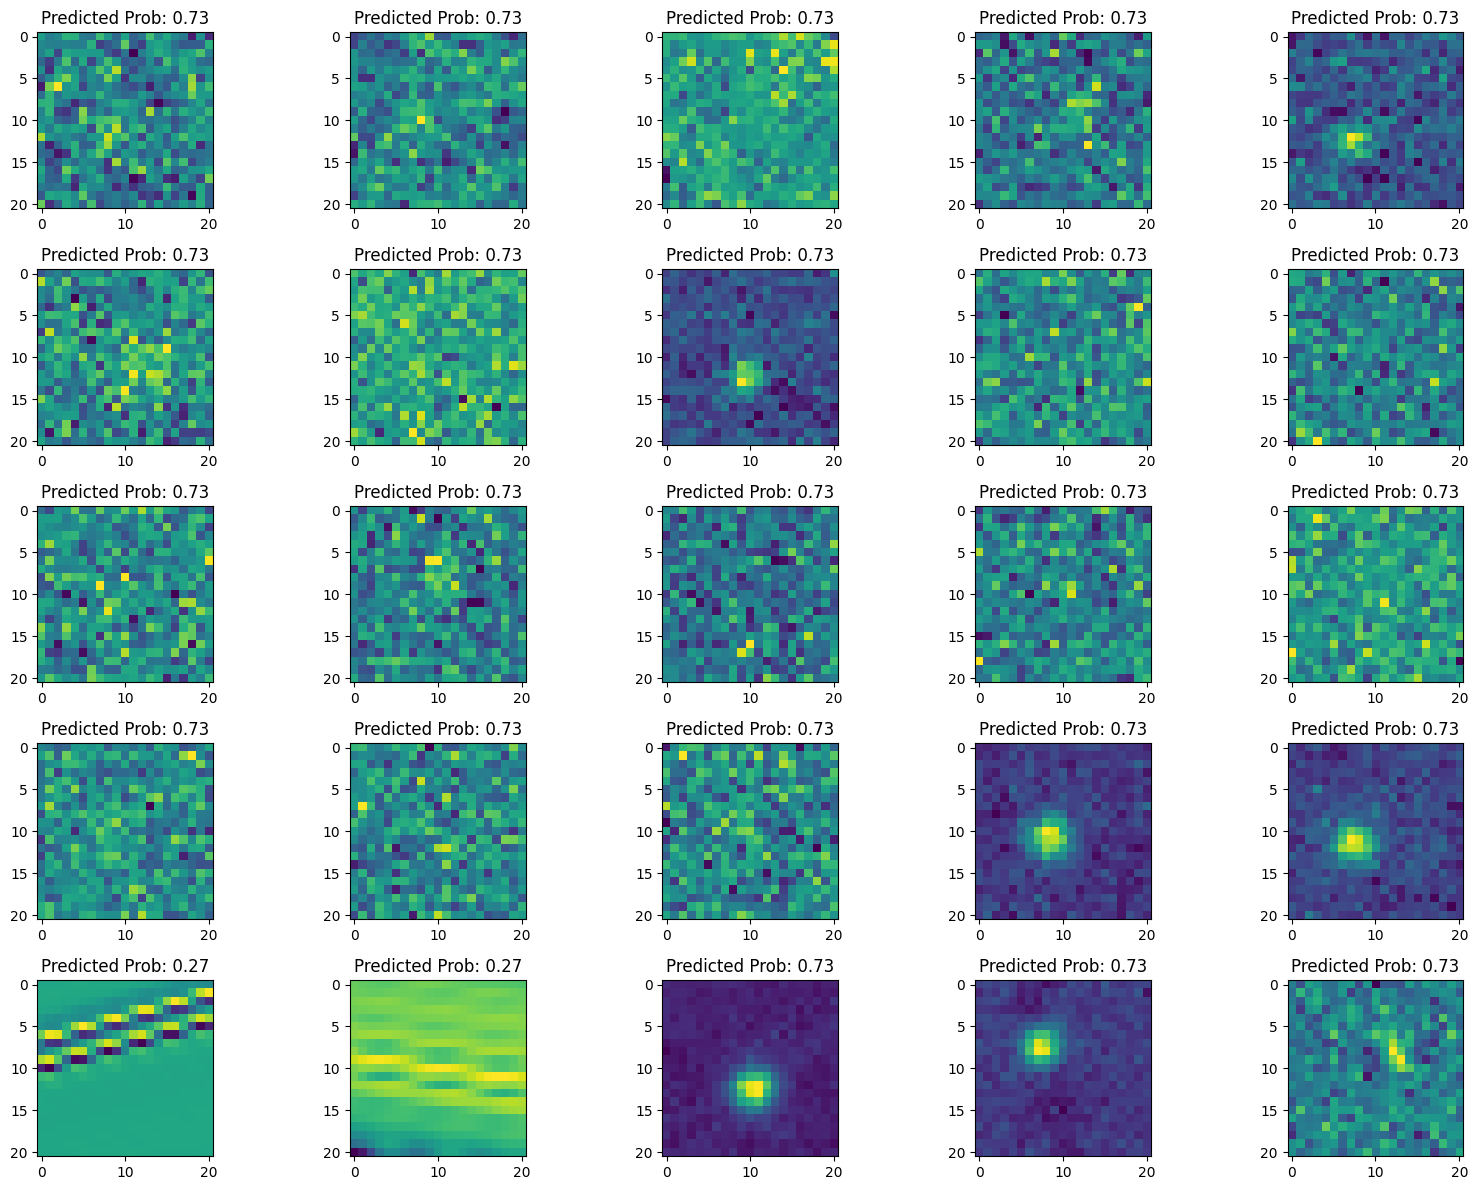

In [ ]:
import torch
import matplotlib.pyplot as plt

# Aqui parametrizamos el numero de imágenes que que queremos mostrar
n = 25  # Numero imagenes
num_cols = 5  # Numero de columnas en el grafico
num_rows = (n + num_cols - 1) // num_cols  # Calcula el numero de filas

# Ponemos el modelo en eval
model.eval()

# Conversion datos a tensores de pytorch
real_positives_tensor = torch.tensor(true_test[:, 0, :, :], dtype=torch.float32).unsqueeze(1)

# Calcula las probabilidades de prediccion
with torch.no_grad():
    real_data_probs = torch.softmax(model(real_positives_tensor[:n]), dim=1)  # Predicción de las primeras n imagenes

# Se convierten las probabilidades de pytorch a numpy visualizar
real_data_probs = real_data_probs[:, 1].cpu().numpy()  # Probabilidad de la clase "verdadero positivo"

# Graficamos
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=[16, 12])
ax = ax.flatten()
for tmp_ax in ax:
    tmp_ax.set_axis_off()

for i, coadd in enumerate(true_test[:n]):
    ax[i].set_axis_on()
    ax[i].imshow(coadd[0], cmap='viridis')
    ax[i].set_title(f'Predicted Prob: {real_data_probs[i]:.2f}')

plt.tight_layout()
plt.show()


## Resnet

In [16]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 57.7 MB/s eta 0:00:00


In [57]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchvision.models as models
import torchvision.transforms as transforms
from torchmetrics import Accuracy
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.classification import Accuracy

from torchmetrics.classification import Precision, Recall

class ResNet50TransferLearning(pl.LightningModule):
    def __init__(self, num_classes=2, learning_rate=1e-4):
        super(ResNet50TransferLearning, self).__init__()
        self.save_hyperparameters()

        # Cargamos el modelo preentrenado
        self.model = models.resnet50(pretrained=True)

        # Decidimos si congelamos todas las capas excepto la nueva capa final
        for param in self.model.parameters():
            param.requires_grad = True # True = fine-tuning, false = feature extract

        # Reemplazamos la última capa para la clasificación
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

        self.criterion = nn.CrossEntropyLoss()

        # Métricas de precisión, recall y accuracy
        self.accuracy = Accuracy(task="binary") if num_classes == 2 else Accuracy(task="multiclass", num_classes=num_classes)
        self.precision = Precision(task="binary") if num_classes == 2 else Precision(task="multiclass", num_classes=num_classes)
        self.recall = Recall(task="binary") if num_classes == 2 else Recall(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)

        # Convertimos las predicciones en índices de clase
        preds = y_hat.argmax(dim=-1)
        acc = self.accuracy(preds, y)
        precision = self.precision(preds, y)
        recall = self.recall(preds, y)

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_accuracy', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_precision', precision, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_recall', recall, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)

        # Convertimos las predicciones en índices de clase
        preds = y_hat.argmax(dim=-1)
        acc = self.accuracy(preds, y)
        precision = self.precision(preds, y)
        recall = self.recall(preds, y)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_precision', precision, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_recall', recall, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=self.hparams.learning_rate)
        return optimizer



In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# class ResNet50TransferLearning(pl.LightningModule):
#     def __init__(self, num_classes=2, learning_rate=1e-4):
#         super(ResNet50TransferLearning, self).__init__()
#         self.save_hyperparameters()

#         # Cargamos el modelo preentrenado
#         self.model = models.resnet50(pretrained=True)

#         # Congelamos todas las capas excepto la nueva capa final
#         for param in self.model.parameters():
#             param.requires_grad = False

#         # Reemplazamos la última capa para la clasificación
#         num_features = self.model.fc.in_features
#         self.model.fc = nn.Linear(num_features, num_classes)

#         self.criterion = nn.CrossEntropyLoss()

#         # Métrica de precisión para clasificación binaria
#         self.accuracy = Accuracy(task="binary") if num_classes == 2 else Accuracy(task="multiclass", num_classes=num_classes)

#     def forward(self, x):
#         return self.model(x)

#     def training_step(self, batch, batch_idx):
#         x, y = batch
# #        x, y = x.to(device), y.to(device)
#         y_hat = self(x)
#         loss = self.criterion(y_hat, y)

#         # Convertimos las predicciones en índices de clase
#         preds = y_hat.argmax(dim=-1)
#         acc = self.accuracy(preds, y)

#         self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
#         self.log('train_accuracy', acc, on_step=False, on_epoch=True, prog_bar=True)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         x, y = batch
# #        x, y = x.to(device), y.to(device)
#         y_hat = self(x)
#         loss = self.criterion(y_hat, y)

#         # Convertimos las predicciones en índices de clase
#         preds = y_hat.argmax(dim=-1)
#         acc = self.accuracy(preds, y)

#         self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
#         self.log('val_accuracy', acc, on_step=False, on_epoch=True, prog_bar=True)
#         return loss

#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=self.hparams.learning_rate)
#         return optimizer


In [58]:
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

class MetricsCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.metrics = {
            "train_loss": [], "train_accuracy": [], "train_precision": [], "train_recall": [],
            "val_loss": [], "val_accuracy": [], "val_precision": [], "val_recall": []
        }

    def on_train_epoch_end(self, trainer, pl_module):
        # Métricas de entrenamiento
        self.metrics["train_loss"].append(trainer.callback_metrics["train_loss"].item())
        self.metrics["train_accuracy"].append(trainer.callback_metrics["train_accuracy"].item())
        self.metrics["train_precision"].append(trainer.callback_metrics["train_precision"].item())
        self.metrics["train_recall"].append(trainer.callback_metrics["train_recall"].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        # Métricas de validación
        self.metrics["val_loss"].append(trainer.callback_metrics["val_loss"].item())
        self.metrics["val_accuracy"].append(trainer.callback_metrics["val_accuracy"].item())
        self.metrics["val_precision"].append(trainer.callback_metrics["val_precision"].item())
        self.metrics["val_recall"].append(trainer.callback_metrics["val_recall"].item())


# Instancia del Callback
metrics_callback = MetricsCallback()

In [20]:
from torchvision import transforms

# Transformaciones para el conjunto de entrenamiento (con data augmentation)
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),       # Repetir el canal para obtener 3 canales
    transforms.RandomHorizontalFlip(p=0.5),               # Flip horizontal aleatorio
    transforms.RandomVerticalFlip(p=0.5),                 # Flip vertical aleatorio
    transforms.RandomRotation(degrees=30),                # Rotación aleatoria (-30° a 30°)
])

# Transformaciones para validación y test (sin data augmentation)
val_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),       # Repetir el canal para obtener 3 canales

])

# Aplicar transformaciones al conjunto de datos
train_data_tensor = torch.tensor(train_data, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, 1, 21, 21)
train_class_tensor = torch.tensor(train_class.argmax(axis=1), dtype=torch.long)

val_data_tensor = torch.tensor(val_data, dtype=torch.float32).permute(0, 3, 1, 2)
val_class_tensor = torch.tensor(val_class.argmax(axis=1), dtype=torch.long)

# Aplicar transformaciones al conjunto de entrenamiento
train_data_transformed = torch.stack([train_transform(img) for img in train_data_tensor])
val_data_transformed = torch.stack([val_transform(img) for img in val_data_tensor])

# Crear conjuntos de datos y DataLoaders
train_dataset = TensorDataset(train_data_transformed, train_class_tensor)
val_dataset = TensorDataset(val_data_transformed, val_class_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [21]:
assert not torch.isnan(train_data_tensor).any(), "Hay valores NaN en los datos de entrenamiento"
assert not torch.isinf(train_data_tensor).any(), "Hay valores infinitos en los datos de entrenamiento"

In [76]:
# Configuración para reproducibilidad
pl.seed_everything(42)

# Instancia del callback de métricas
metrics_callback = MetricsCallback()

# Configuración de otros callbacks
# checkpoint_callback = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min", filename="best_model")
# early_stopping_callback = EarlyStopping(monitor="val_loss", patience=5, mode="min")# Si el val loss no mejora en 3 epocas, etenemos el fit
checkpoint_callback = ModelCheckpoint(monitor="val_recall", save_top_k=1, mode="max", filename="best_model")
early_stopping_callback = EarlyStopping(monitor="val_recall", patience=5, mode="max")
lr_monitor = LearningRateMonitor(logging_interval="epoch")
logger = TensorBoardLogger("tb_logs", name="ResNet50_Transfer")

# Entrenamiento del modelo con callbacks
model = ResNet50TransferLearning(num_classes=2, learning_rate=1e-4)
trainer = pl.Trainer(
    max_epochs=20,
    callbacks=[checkpoint_callback, early_stopping_callback, lr_monitor, metrics_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    logger=logger
)

# Entrenar el modelo
trainer.fit(model, train_loader, val_loader)

# Recuperar los valores de métricas al final del entrenamiento
train_loss = metrics_callback.metrics["train_loss"]
train_accuracy = metrics_callback.metrics["train_accuracy"]
train_precision = metrics_callback.metrics["train_precision"]  # Nueva métrica
train_recall = metrics_callback.metrics["train_recall"]        # Nueva métrica
val_loss = metrics_callback.metrics["val_loss"]
val_accuracy = metrics_callback.metrics["val_accuracy"]
val_precision = metrics_callback.metrics["val_precision"]      # Nueva métrica
val_recall = metrics_callback.metrics["val_recall"]            # Nueva métrica

INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Resultados usando el val_data en validacion.

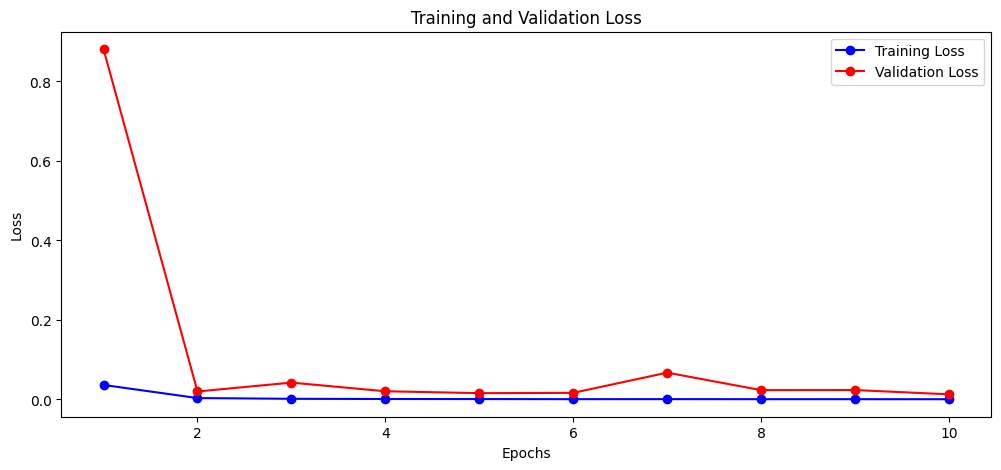

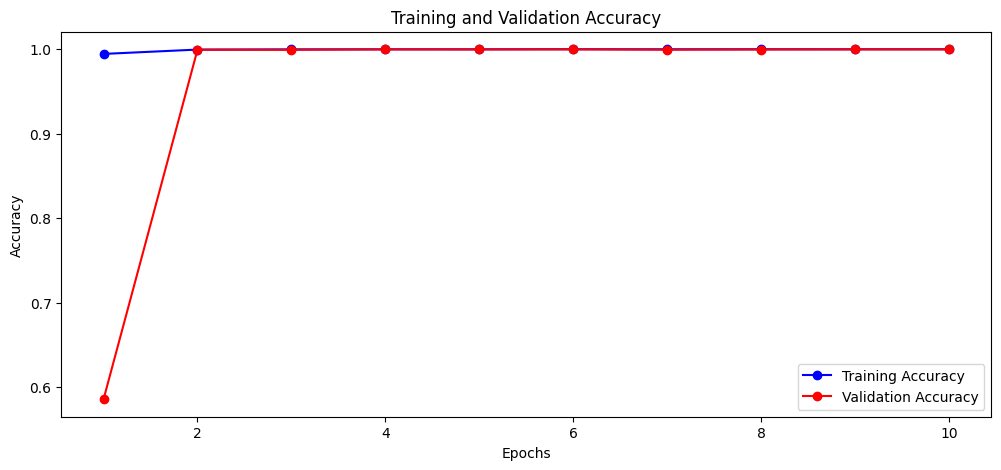

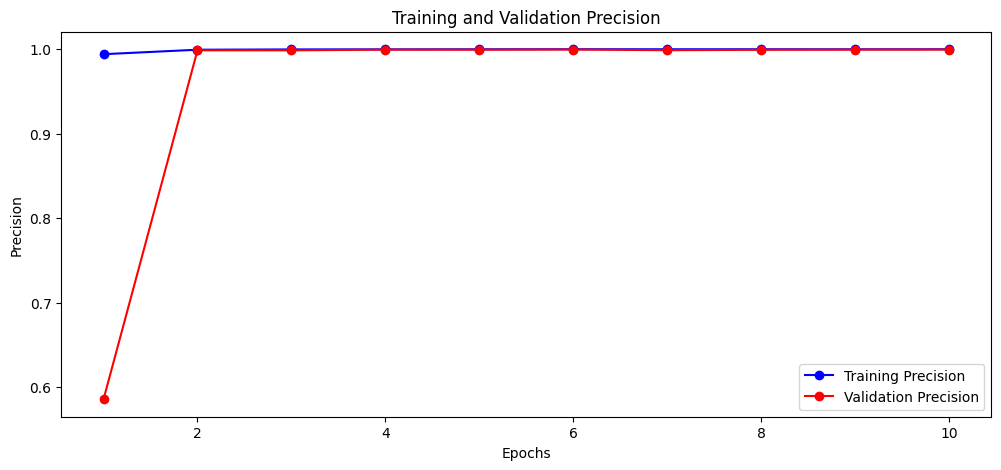

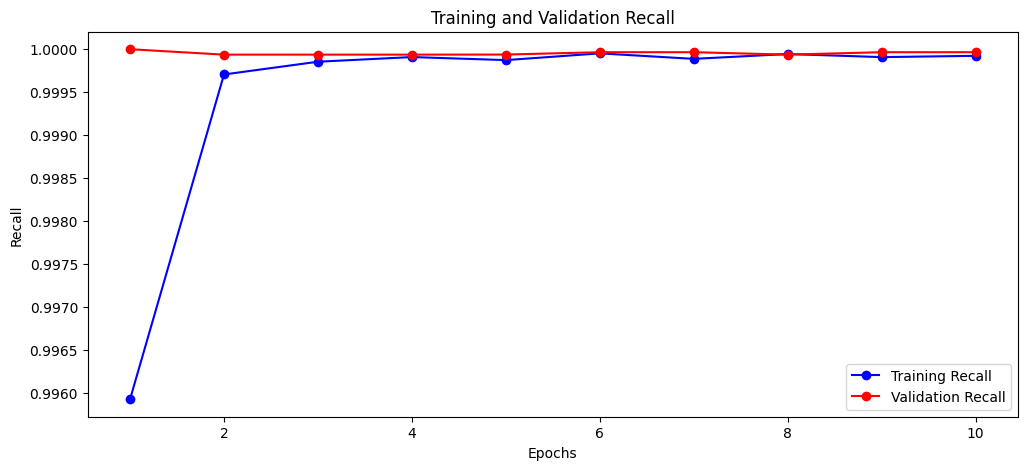

In [77]:
# Asegurarse de que las listas tienen la misma longitud
min_len = min(len(train_loss), len(val_loss), len(train_accuracy), len(val_accuracy))
train_loss = train_loss[:min_len]
val_loss = val_loss[:min_len]
train_accuracy = train_accuracy[:min_len]
val_accuracy = val_accuracy[:min_len]
train_precision = train_precision[:min_len]
val_precision = val_precision[:min_len]
train_recall = train_recall[:min_len]
val_recall = val_recall[:min_len]
epochs = list(range(1, min_len + 1))


# Loss Figure
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()  # Display the Loss figure

# Accuracy Figure
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()  # Display the Accuracy figure

# Precision Figure
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_precision, 'bo-', label='Training Precision')
plt.plot(epochs, val_precision, 'ro-', label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Training and Validation Precision')
plt.show()  # Display the Precision figure

# Recall Figure
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_recall, 'bo-', label='Training Recall')
plt.plot(epochs, val_recall, 'ro-', label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Training and Validation Recall')
plt.show()  # Display the Recall figure

Resultados usando el test_data en validacion:

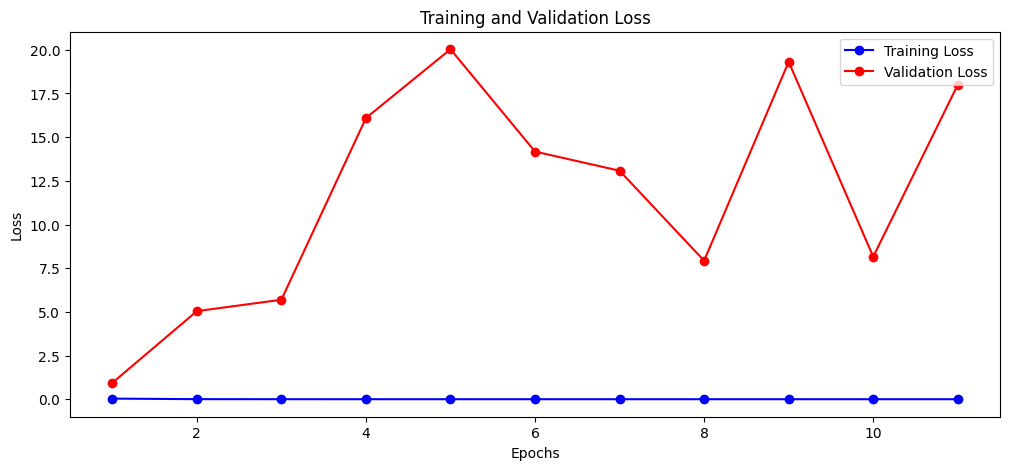

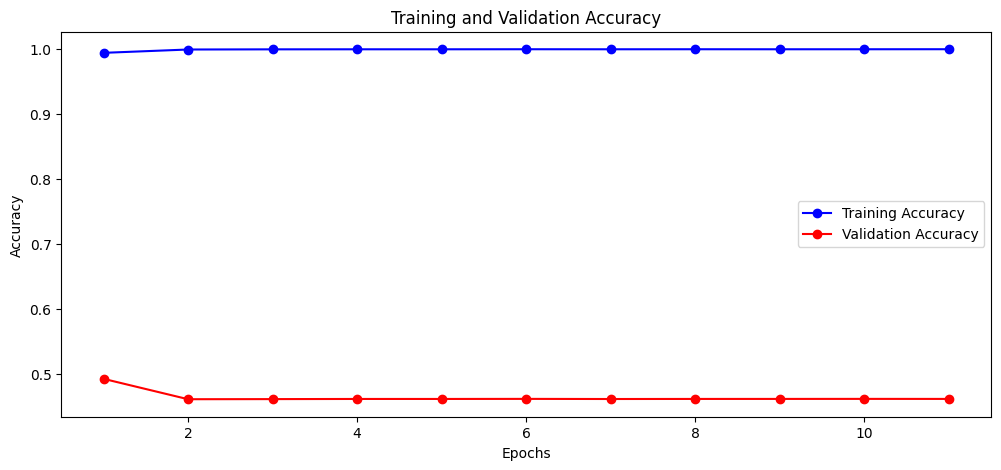

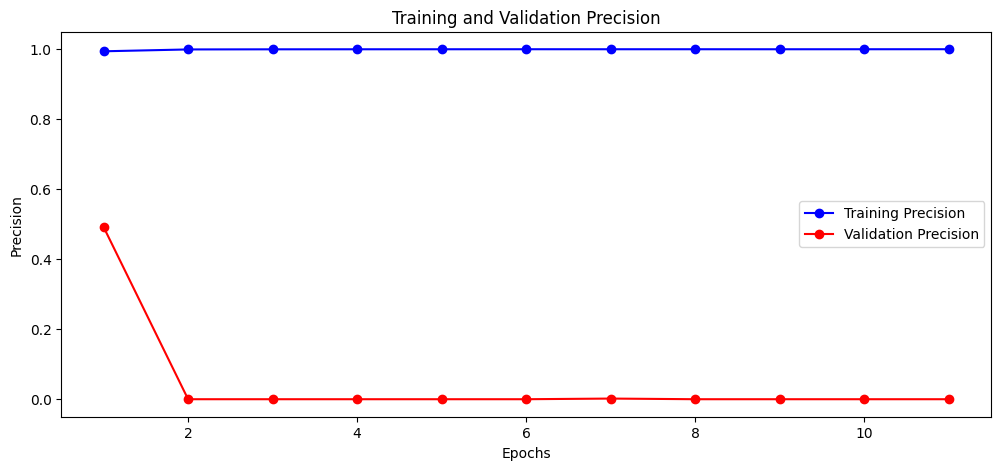

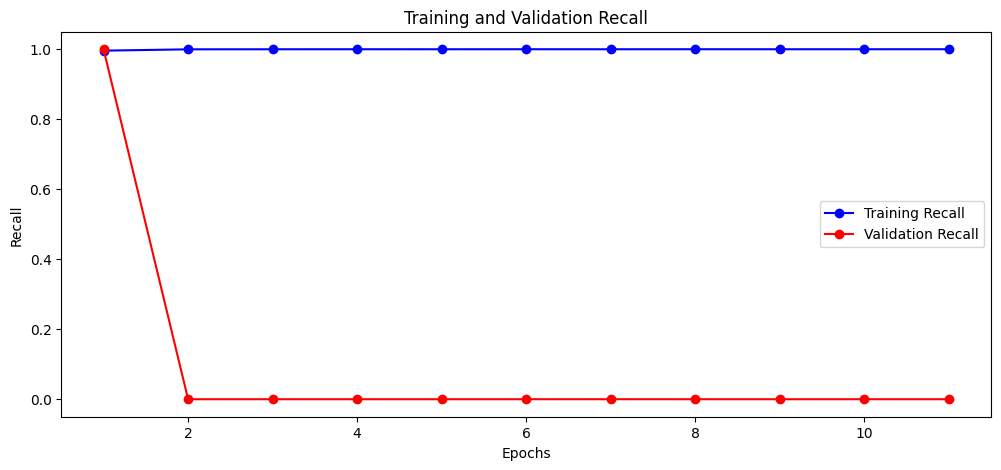

In [54]:
# # Asegurarse de que las listas tienen la misma longitud
# min_len = min(len(train_loss), len(val_loss), len(train_accuracy), len(val_accuracy))
# train_loss = train_loss[:min_len]
# val_loss = val_loss[:min_len]
# train_accuracy = train_accuracy[:min_len]
# val_accuracy = val_accuracy[:min_len]
# train_precision = train_precision[:min_len]
# val_precision = val_precision[:min_len]
# train_recall = train_recall[:min_len]
# val_recall = val_recall[:min_len]
# epochs = list(range(1, min_len + 1))


# # Loss Figure
# plt.figure(figsize=(12, 5))
# plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
# plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training and Validation Loss')
# plt.show()  # Display the Loss figure

# # Accuracy Figure
# plt.figure(figsize=(12, 5))
# plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
# plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Training and Validation Accuracy')
# plt.show()  # Display the Accuracy figure

# # Precision Figure
# plt.figure(figsize=(12, 5))
# plt.plot(epochs, train_precision, 'bo-', label='Training Precision')
# plt.plot(epochs, val_precision, 'ro-', label='Validation Precision')
# plt.xlabel('Epochs')
# plt.ylabel('Precision')
# plt.legend()
# plt.title('Training and Validation Precision')
# plt.show()  # Display the Precision figure

# # Recall Figure
# plt.figure(figsize=(12, 5))
# plt.plot(epochs, train_recall, 'bo-', label='Training Recall')
# plt.plot(epochs, val_recall, 'ro-', label='Validation Recall')
# plt.xlabel('Epochs')
# plt.ylabel('Recall')
# plt.legend()
# plt.title('Training and Validation Recall')
# plt.show()  # Display the Recall figure

In [63]:
# Ruta al checkpoint guardado
checkpoint_path = "tb_logs/ResNet50_Transfer/version_0/checkpoints/best_model.ckpt" # Aqui se guardan los modelos usando ModelCheckpoint, en version_i estara em mejor modelo producto de correr el training por i_esima vez.

# Cargar el modelo desde el checkpoint
best_model = ResNet50TransferLearning.load_from_checkpoint(checkpoint_path)

# Cambiar a modo evaluación
best_model.eval()

# Si estás utilizando GPU y el modelo estaba entrenado en GPU
if torch.cuda.is_available():
    best_model = best_model.to('cuda')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
# Aplicar transformaciones al conjunto de datos
test_data_tensor = torch.tensor(test_data, dtype=torch.float32).permute(0, 3, 1, 2)
test_class_tensor = torch.tensor(test_class.argmax(axis=1), dtype=torch.long)

# Aplicar transformaciones al conjunto de entrenamiento
test_data_transformed = torch.stack([val_transform(img) for img in test_data_tensor])

# Crear conjuntos de datos y DataLoaders
test_dataset = TensorDataset(test_data_transformed, test_class_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)


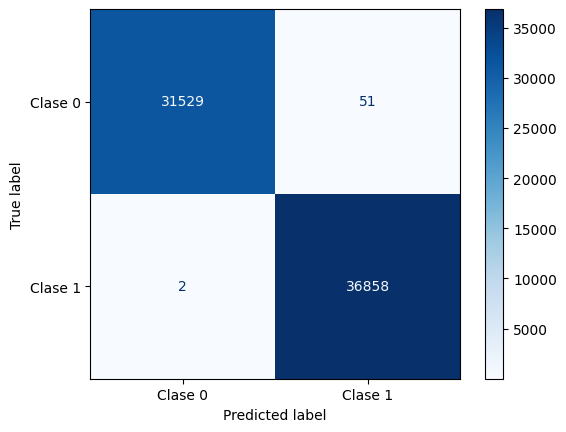

In [64]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Preparación de datos de prueba
true_labels = []  # Etiquetas verdaderas
predicted_labels = []  # Predicciones del modelo

# Evaluación en el conjunto de test
with torch.no_grad():
    for batch in val_loader:  # Asumiendo que tienes un `DataLoader` para tu conjunto de test
        x, y = batch
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')

        # Realizamos la inferencia
        y_hat = best_model(x)
        preds = y_hat.argmax(dim=1)  # Predicciones de clase

        # Almacenamos las etiquetas verdaderas y las predicciones
        true_labels.extend(y.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Convertimos a arrays de numpy
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculamos la matriz de confusión
cm = confusion_matrix(true_labels, predicted_labels)

# Visualizamos la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Clase 0", "Clase 1"])
disp.plot(cmap="Blues")
plt.show()

Como vemos los resultados en validacion son bastante buenos.

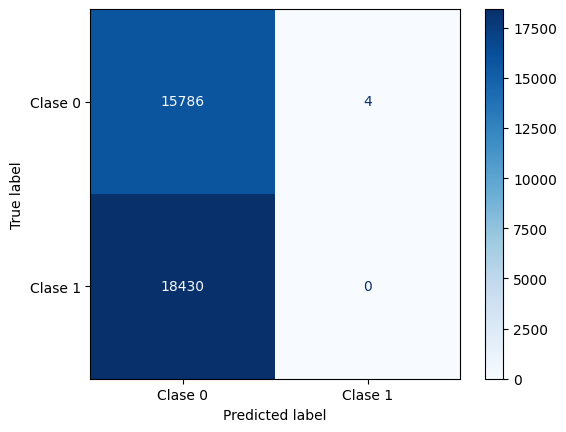


=== Métricas para el conjunto de test ===

              precision    recall  f1-score   support

     Clase 0       0.46      1.00      0.63     15790
     Clase 1       0.00      0.00      0.00     18430

    accuracy                           0.46     34220
   macro avg       0.23      0.50      0.32     34220
weighted avg       0.21      0.46      0.29     34220



In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Preparación de datos de prueba
true_labels = []
predicted_labels = []

# Evaluación en el conjunto de test
with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')

        # Realizamos la inferencia
        y_hat = best_model(x)
        preds = y_hat.argmax(dim=1)

        # Almacenamos las etiquetas verdaderas y las predicciones
        true_labels.extend(y.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Convertimos a arrays de numpy
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculamos la matriz de confusión
cm = confusion_matrix(true_labels, predicted_labels)

# Visualizamos la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Clase 0", "Clase 1"])
disp.plot(cmap="Blues")
plt.show()

# Calculamos las métricas: accuracy, precision, recall, F1-score
print("\n=== Métricas para el conjunto de test ===\n")
print(classification_report(true_labels, predicted_labels, target_names=["Clase 0", "Clase 1"]))

Sin embargo evluando con los datos de test es muy pobre

In [46]:
# import torch
# import matplotlib.pyplot as plt

# # Aqui parametrizamos el numero de imágenes que que queremos mostrar
# n = 25  # Numero imagenes
# num_cols = 5  # Numero de columnas en el grafico
# num_rows = (n + num_cols - 1) // num_cols  # Calcula el numero de filas

# # Ponemos el modelo en eval
# model.eval()

# # Conversion datos a tensores de pytorch
# real_positives_tensor = torch.tensor(true_test[:, 0, :, :], dtype=torch.float32).unsqueeze(1)
# if torch.cuda.is_available():
#     real_positives_tensor = real_positives_tensor.to('cuda')

# # Calcula las probabilidades de prediccion
# with torch.no_grad():
#     real_data_probs = torch.softmax(model(real_positives_tensor[:n]), dim=1)  # Predicción de las primeras n imagenes

# # Se convierten las probabilidades de pytorch a numpy visualizar
# real_data_probs = real_data_probs[:, 1].cpu().numpy()  # Probabilidad de la clase "verdadero positivo"

# # Graficamos
# fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=[16, 12])
# ax = ax.flatten()
# for tmp_ax in ax:
#     tmp_ax.set_axis_off()

# for i, coadd in enumerate(true_test[:n]):
#     ax[i].set_axis_on()
#     ax[i].imshow(coadd[0], cmap='viridis')
#     ax[i].set_title(f'Predicted Prob: {real_data_probs[i]:.2f}')

# plt.tight_layout()
# plt.show()

### Rango intesidad de las imagenes

In [ ]:
min_intensity =  train_data.min().item()
max_intensity = train_data.max().item()

print(f"Minimum intensity: {min_intensity}")
print(f"Maximum intensity: {max_intensity}")

Minimum intensity: 0.0
Maximum intensity: 1.0


In [ ]:
min_intensity = train_data_tensor.min().item()
max_intensity = train_data_tensor.max().item()

print(f"Minimum intensity: {min_intensity}")
print(f"Maximum intensity: {max_intensity}")

Minimum intensity: 0.0
Maximum intensity: 1.0


In [ ]:
train_data_tensor.shape

torch.Size([239540, 21, 1, 21])